# Real fields - Maxey-Riley equations slow manifold

In [60]:
from typing import Any, Callable, Dict
import json

import cartopy.crs as ccrs
import cmocean.cm as cmo
import diffrax as dfx
import equinox as eqx
import interpax as ipx
import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, PyTree, Real
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from jaxparrow import cyclogeostrophy
from jaxparrow.tools.operators import interpolation

from pastax.gridded import Gridded, spatial_derivative
from pastax.simulator import DeterministicSimulator, DiffraxSimulator
from pastax.trajectory import Location, Trajectory
from pastax.utils import distance_on_earth, meters_to_degrees, degrees_to_meters

from matplotlib import animation
from IPython.display import HTML
import cartopy.crs as ccrs
import pandas as pd
import os
from matplotlib.collections import LineCollection


In [61]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl
fs = 12
rc('legend', fontsize=fs)
rc('axes',   labelsize=fs)
rc('xtick',  labelsize=fs)
rc('ytick',  labelsize=fs)
rc('lines',  markersize=7)
rc('lines',  linewidth=1.5)
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

In [62]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

## Input data

In [63]:
data_path = '/home/samantha/Documents/SL/measurements/post_processing/' # samantha
drifters_path = '/home/samantha/Documents/SL/otc25-final_report/data/drifters/l2/'

### Drifter trajectories

In [64]:
melodi_l2_df = pd.read_parquet(os.path.join(drifters_path, "melodi_l2_df.parquet"))

In [65]:
melodi_l2_df

42244 rows × 8 columns

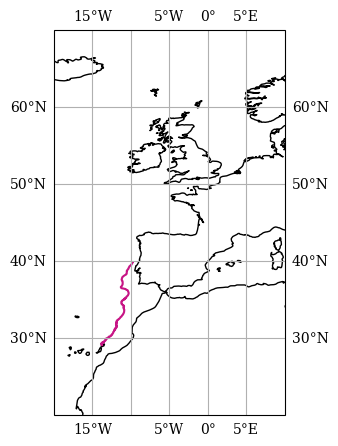

In [66]:
fig, ax = plt.subplots(
    figsize=(6.5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
traj_ids = melodi_l2_df["traj_id"].drop_duplicates().sort_values()
chosen_id = 30
#for traj_id in traj_ids:
    #subset = melodi_l2_df[melodi_l2_df["traj_id"] == traj_id]
subset = melodi_l2_df[melodi_l2_df["traj_id"] == chosen_id]
ax.plot(subset.lon.values, subset.lat.values, c = 'mediumvioletred')

ax.set_xlim([-20,10])
ax.set_ylim([20,70])

#ax.legend(loc="lower right")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

In [67]:
subset.deploy_time.values

array(['2025-05-23T05:45:00.000000000', '2025-05-23T05:45:00.000000000',
       '2025-05-23T05:45:00.000000000', ...,
       '2025-05-23T05:45:00.000000000', '2025-05-23T05:45:00.000000000',
       '2025-05-23T05:45:00.000000000'], dtype='datetime64[ns]')

In [68]:
start_time = np.datetime64("2025-05-24T12:00:00")
horizon_days = 7

In [69]:
def get_trajectory(traj)-> Trajectory:

        ts = []
        lat = []
        lon = []
        t0 = None
        for sample in traj:
            t = sample["time"]
            
            if np.datetime64(t) < start_time:
                continue
            if t0 is None:
                t0 = np.datetime64(t)
            if np.datetime64(t) > start_time + np.timedelta64(horizon_days, "D"):
                break

            ts.append(t)
            lat.append(sample["lat"])
            lon.append(sample["lon"])

        return Trajectory.from_array(
            jnp.stack((jnp.asarray(lat), jnp.asarray(lon)), axis=-1), 
            jnp.asarray(np.asarray(ts).astype("datetime64[s]").astype(int))
        )

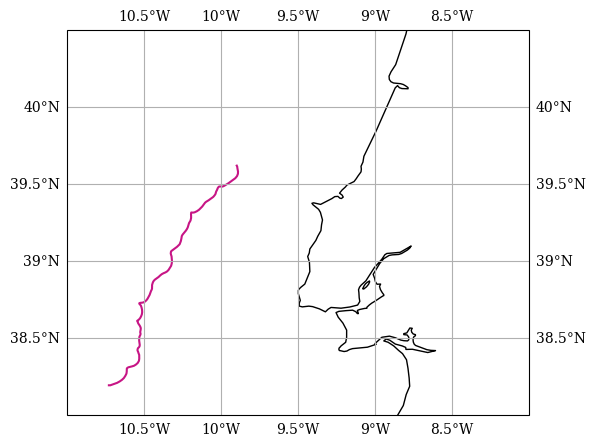

In [70]:
#melodi_traj_ds = subset[subset['time']<start_time + np.timedelta64(horizon_days, "D")]
melodi_traj_ds = subset[
    (subset['time'] >= start_time) & 
    (subset['time'] < start_time + np.timedelta64(horizon_days, "D"))]

melodi_traj = Trajectory.from_array(
            jnp.stack((jnp.asarray(melodi_traj_ds.lat), jnp.asarray(melodi_traj_ds.lon)), axis=-1), 
            jnp.asarray(np.asarray(melodi_traj_ds.time).astype("datetime64[s]").astype(int))
        )

fig, ax = plt.subplots(
    figsize=(6.5, 5),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
traj_ids = melodi_l2_df["traj_id"].drop_duplicates().sort_values()
chosen_id = 30
#for traj_id in traj_ids:
    #subset = melodi_l2_df[melodi_l2_df["traj_id"] == traj_id]
subset = melodi_l2_df[melodi_l2_df["traj_id"] == chosen_id]
ax.plot(melodi_traj.value[:,1], melodi_traj.value[:,0], c = 'mediumvioletred')

ax.set_xlim([-11,-8])
ax.set_ylim([38,40.5])

#ax.legend(loc="lower right")

ax.coastlines()
ax.gridlines(draw_labels=True)

plt.show()

In [71]:
melodi_x0 = melodi_traj.origin
melodi_ts = melodi_traj.times.value

### Forcings

In [72]:
min_lat, max_lat = (melodi_x0.latitude - 2).value.item(), (melodi_x0.latitude + 2).value.item()
min_lon, max_lon = (melodi_x0.longitude - 2).value.item(), (melodi_x0.longitude + 2).value.item()
min_time = start_time.astype("datetime64[D]")
max_time = start_time.astype("datetime64[D]") + np.timedelta64(1 + horizon_days, "D")

In [73]:
def get_latlon_from_idf(ds: xr.Dataset) -> (np.ndarray, np.ndarray):
    def do_transform(coord_name: str):
        d = np.diff(ds[f"{coord_name}_gcp"])[0] / np.diff(ds[f"index_{coord_name}_gcp"].values.ravel())[0]
        c0 = float(np.round(ds[f"{coord_name}_gcp"].min().values + d / 2, 3))
        return c0 + ds[coord_name].values * d
    return do_transform("lat"), do_transform("lon")

In [74]:
def preproc_fn(ds: xr.Dataset) -> xr.Dataset:
    ds["lat"], ds["lon"] = get_latlon_from_idf(ds)
    return ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

### Vardyn - cyclogeostrophy

In [75]:
vardyn_dir = data_path + "vardyn_nadir_swot"

In [76]:
vardyn_ds = xr.open_dataset(f"{vardyn_dir}/VarDyn_OTC25_swot_nadirs.nc")
vardyn_ds = vardyn_ds.sel(
    time=slice(min_time, max_time), 
    latitude=slice(min_lat, max_lat), 
    longitude=slice(min_lon, max_lon)
)
vardyn_ds

<xarray.Dataset> Size: 1MB
Dimensions: (time: 9, latitude: 48, longitude: 48)
Coordinates:
 * time (time) datetime64[ns] 72B 2025-05-24 2025-05-25 ... 2025-06-01
 * longitude (longitude) float64 384B -11.83 -11.75 -11.67 ... -8.0 -7.917
 * latitude (latitude) float64 384B 37.67 37.75 37.83 ... 41.42 41.5 41.58
Data variables:
 sla (time, latitude, longitude) float64 166kB ...
 adt (time, latitude, longitude) float64 166kB ...
 sst (time, latitude, longitude) float64 166kB ...
 ugos (time, latitude, longitude) float64 166kB ...
 vgos (time, latitude, longitude) float64 166kB ...
 ucos (time, latitude, longitude) float64 166kB ...
 vcos (time, latitude, longitude) float64 166kB ...
Attributes:
 titre: VarDyn SSH/SST estimation using nadir altimetry, SWOT, and ...
 institution: Datlas
 history: 2025-08-21 16:03:41.179858: Creation xarray.Dataset Dimensions: time : 9 latitude : 48 longitude : 48 Coordinates: (3) time (time) datetime64[ns] 2025-05-24 ... 2025-06-01 array(['2025-05-24T00:00:00.000000000', '2025-05-25T00:00:00.000000000',
 '2025-05-26T00:00:00.000000000', '2025-05-27T00:00:00.000000000',
 '2025-05-28T00:00:00.000000000', '2025-05-29T00:00:00.000000000',
 '2025-05-30T00:00:00.000000000', '2025-05-31T00:00:00.000000000',
 '2025-06-01T00:00:00.000000000'], dtype='datetime64[ns]') longitude (longitude) float64 -11.83 -11.75 ... -8.0 -7.917 axis : X long_name : Longitude standard_name : longitude units : degrees_east valid_max : 179.9375 valid_min : -179.9375 bounds : lon_bnds array([-11.833333, -11.75 , -11.666667, -11.583333, -11.5 , -11.416667,
 -11.333333, -11.25 , -11.166667, -11.083333, -11. , -10.916667,
 -10.833333, -10.75 , -10.666667, -10.583333, -10.5 , -10.416667,
 -10.333333, -10.25 , -10.166667, -10.083333, -10. , -9.916667,
 -9.833333, -9.75 , -9.666667, -9.583333, -9.5 , -9.416667,
 -9.333333, -9.25 , -9.166667, -9.083333, -9. , -8.916667,
 -8.833333, -8.75 , -8.666667, -8.583333, -8.5 , -8.416667,
 -8.333333, -8.25 , -8.166667, -8.083333, -8. , -7.916667]) latitude (latitude) float64 37.67 37.75 37.83 ... 41.5 41.58 long_name : Latitude valid_max : 89.9375 axis : Y standard_name : latitude bounds : lat_bnds units : degrees_north valid_min : -89.9375 array([37.666667, 37.75 , 37.833333, 37.916667, 38. , 38.083333,
 38.166667, 38.25 , 38.333333, 38.416667, 38.5 , 38.583333,
 38.666667, 38.75 , 38.833333, 38.916667, 39. , 39.083333,
 39.166667, 39.25 , 39.333333, 39.416667, 39.5 , 39.583333,
 39.666667, 39.75 , 39.833333, 39.916667, 40. , 40.083333,
 40.166667, 40.25 , 40.333333, 40.416667, 40.5 , 40.583333,
 40.666667, 40.75 , 40.833333, 40.916667, 41. , 41.083333,
 41.166667, 41.25 , 41.333333, 41.416667, 41.5 , 41.583333]) Data variables: (7) sla (time, latitude, longitude) float64 ... ancillary_variables : err_sla comment : The sea level anomaly is the sea surface height above mean sea surface; it is referenced to the [1993, 2012] period; see the product user manual for details grid_mapping : crs long_name : Sea level anomaly standard_name : sea_surface_height_above_sea_level units : m [20736 values with dtype=float64] adt (time, latitude, longitude) float64 ... comment : The absolute dynamic topography is the sea surface height above geoid; the adt is obtained as follows: adt=sla+mdt where mdt is the mean dynamic topography; see the product user manual for details grid_mapping : crs long_name : Absolute dynamic topography standard_name : sea_surface_height_above_geoid units : m [20736 values with dtype=float64] sst (time, latitude, longitude) float64 ... long_name : Sea Surface Temperature standard_name : sea_surface_temperature units : K [20736 values with dtype=float64] ugos (time, latitude, longitude) float64 ... grid_mapping : crs long_name : Absolute geostrophic velocity: zonal component standard_name : surface_geostrophic_eastward_sea_water_velocity units : m/s [20736 values with dtype=float64] vgos (time, latitude, longitude) float64 ... grid_mapping : crs long_name : Absolute cyclogeostrophic ve

In [77]:
lon_t, lat_t = jnp.meshgrid(vardyn_ds.longitude.values, vardyn_ds.latitude.values)
sla_t = vardyn_ds.sla.values
mask = ~(jnp.isfinite(sla_t))

In [78]:
vmap_cyclogeostrophy = jax.vmap(
    lambda *args: cyclogeostrophy(*args, return_grids=False), in_axes=(0, None, None, 0)
)
u_cg_u, v_cg_v = vmap_cyclogeostrophy(sla_t, lat_t, lon_t, mask)

In [79]:
vmap_interpolation = jax.vmap(
    lambda *args: interpolation(*args, padding="left"), in_axes=(0, 0, None)
)

u_cg = vmap_interpolation(u_cg_u, mask, 1)
v_cg = vmap_interpolation(v_cg_v, mask, 0)

In [80]:
vardyn_ds["u_cg"] = (("time", "lat", "lon"), u_cg)
vardyn_ds["v_cg"] = (("time", "lat", "lon"), v_cg)

In [81]:
vardyn_gridded = Gridded.from_xarray(
    vardyn_ds, 
    {"u": "u_cg", "v": "v_cg"}, 
    {"time": "time", "latitude": "lat", "longitude": "lon"}
)

In [82]:
vardyn_ds

<xarray.Dataset> Size: 1MB
Dimensions: (time: 9, latitude: 48, longitude: 48, lat: 48, lon: 48)
Coordinates:
 * time (time) datetime64[ns] 72B 2025-05-24 2025-05-25 ... 2025-06-01
 * longitude (longitude) float64 384B -11.83 -11.75 -11.67 ... -8.0 -7.917
 * latitude (latitude) float64 384B 37.67 37.75 37.83 ... 41.42 41.5 41.58
Dimensions without coordinates: lat, lon
Data variables:
 sla (time, latitude, longitude) float64 166kB 0.1605 0.1571 ... nan
 adt (time, latitude, longitude) float64 166kB ...
 sst (time, latitude, longitude) float64 166kB ...
 ugos (time, latitude, longitude) float64 166kB ...
 vgos (time, latitude, longitude) float64 166kB ...
 ucos (time, latitude, longitude) float64 166kB ...
 vcos (time, latitude, longitude) float64 166kB ...
 u_cg (time, lat, lon) float64 166kB ...
 v_cg (time, lat, lon) float64 166kB ...
Attributes:
 titre: VarDyn SSH/SST estimation using nadir altimetry, SWOT, and ...
 institution: Datlas
 history: 2025-08-21 16:03:41.179858: Creation xarray.Dataset Dimensions: time : 9 latitude : 48 longitude : 48 lat : 48 lon : 48 Coordinates: (3) time (time) datetime64[ns] 2025-05-24 ... 2025-06-01 array(['2025-05-24T00:00:00.000000000', '2025-05-25T00:00:00.000000000',
 '2025-05-26T00:00:00.000000000', '2025-05-27T00:00:00.000000000',
 '2025-05-28T00:00:00.000000000', '2025-05-29T00:00:00.000000000',
 '2025-05-30T00:00:00.000000000', '2025-05-31T00:00:00.000000000',
 '2025-06-01T00:00:00.000000000'], dtype='datetime64[ns]') longitude (longitude) float64 -11.83 -11.75 ... -8.0 -7.917 axis : X long_name : Longitude standard_name : longitude units : degrees_east valid_max : 179.9375 valid_min : -179.9375 bounds : lon_bnds array([-11.833333, -11.75 , -11.666667, -11.583333, -11.5 , -11.416667,
 -11.333333, -11.25 , -11.166667, -11.083333, -11. , -10.916667,
 -10.833333, -10.75 , -10.666667, -10.583333, -10.5 , -10.416667,
 -10.333333, -10.25 , -10.166667, -10.083333, -10. , -9.916667,
 -9.833333, -9.75 , -9.666667, -9.583333, -9.5 , -9.416667,
 -9.333333, -9.25 , -9.166667, -9.083333, -9. , -8.916667,
 -8.833333, -8.75 , -8.666667, -8.583333, -8.5 , -8.416667,
 -8.333333, -8.25 , -8.166667, -8.083333, -8. , -7.916667]) latitude (latitude) float64 37.67 37.75 37.83 ... 41.5 41.58 long_name : Latitude valid_max : 89.9375 axis : Y standard_name : latitude bounds : lat_bnds units : degrees_north valid_min : -89.9375 array([37.666667, 37.75 , 37.833333, 37.916667, 38. , 38.083333,
 38.166667, 38.25 , 38.333333, 38.416667, 38.5 , 38.583333,
 38.666667, 38.75 , 38.833333, 38.916667, 39. , 39.083333,
 39.166667, 39.25 , 39.333333, 39.416667, 39.5 , 39.583333,
 39.666667, 39.75 , 39.833333, 39.916667, 40. , 40.083333,
 40.166667, 40.25 , 40.333333, 40.416667, 40.5 , 40.583333,
 40.666667, 40.75 , 40.833333, 40.916667, 41. , 41.083333,
 41.166667, 41.25 , 41.333333, 41.416667, 41.5 , 41.583333]) Data variables: (9) sla (time, latitude, longitude) float64 0.1605 0.1571 0.153 ... nan nan nan ancillary_variables : err_sla comment : The sea level anomaly is the sea surface height above mean sea surface; it is referenced to the [1993, 2012] period; see the product user manual for details grid_mapping : crs long_name : Sea level anomaly standard_name : sea_surface_height_above_sea_level units : m array([[[0.160525, 0.157052, ..., nan, nan],
 [0.159081, 0.156546, ..., nan, nan],
 ...,
 [0.125836, 0.127965, ..., nan, nan],
 [0.130212, 0.129298, ..., nan, nan]],

 [[0.164508, 0.161201, ..., nan, nan],
 [0.163636, 0.161469, ..., nan, nan],
 ...,
 [0.128399, 0.130094, ..., nan, nan],
 [0.132955, 0.131676, ..., nan, nan]],

 ...,

 [[0.169551, 0.16786 , ..., nan, nan],
 [0.167155, 0.167519, ..., nan, nan],
 ...,
 [0.146972, 0.149017, ..., nan, nan],
 [0.154834, 0.153377, ..., nan, nan]],

 [[0.167889, 0.166309, ..., nan, nan],
 [0.164943, 0.165372, ..., nan, nan],
 ...,
 [0.147663, 0.150036, ..., nan, nan],
 [0.156446, 0.155023, ..., nan, nan]]]) adt (time, latitude, longitude) float64 ... comment : The absolute dyn

### MFWAM - Stokes

In [83]:
# Execute this cell only once

import copernicusmarine

# Download wind data
copernicusmarine.subset(
    dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
    variables=["VSDX", "VSDY"],
    minimum_longitude=min_lon,
    maximum_longitude=max_lon,
    minimum_latitude=min_lat,
    maximum_latitude=max_lat,
    start_datetime=str(start_time),
    end_datetime=str(start_time + np.timedelta64(horizon_days, 'D')),
    output_filename='stokes_data_week_'+ str(min_time) +'.nc',
    output_directory=data_path + "/copernicus_downloaded/"
)

INFO - 2025-10-23T17:15:42Z - Selected dataset version: "202411"
INFO - 2025-10-23T17:15:42Z - Selected dataset part: "default"
INFO - 2025-10-23T17:15:43Z - Starting download. Please wait...
INFO - 2025-10-23T17:15:46Z - Successfully downloaded to /home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded/stokes_data_week_2025-05-24.nc

ResponseSubset(file_path=PosixPath('/home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded/stokes_data_week_2025-05-24.nc'), output_directory=PosixPath('/home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded'), filename='stokes_data_week_2025-05-24.nc', file_size=0.5142519083969466, data_transfer_size=74.04067175572519, variables=['VSDX', 'VSDY'], coordinates_extent=[GeographicalExtent(minimum=-11.833333333333343, maximum=-7.916666666666686, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=37.66666666666666, maximum=41.58333333333333, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2025-05-24T12:00:00+00:00', maximum='2025-05-31T12:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [84]:
mfwam_stokes_ds = xr.open_dataset(data_path + '/copernicus_downloaded/stokes_data_week_'+ str(min_time) +'.nc')

In [85]:
mfwam_stokes_gridded = Gridded.from_xarray(
    mfwam_stokes_ds, 
    {"u": "VSDX", "v": "VSDY"}, 
    {"time": "time", "latitude": "latitude", "longitude": "longitude"}
)

### ECMWF

#### Wind

The data from OTC25 is too heavy for this computer, I use the `copernicusmarine` API

In [86]:
# Execute this cell only once

import copernicusmarine

# Download wind data
copernicusmarine.subset(
    dataset_id="cmems_obs-wind_glo_phy_nrt_l4_0.125deg_PT1H",
    variables=["eastward_wind", "northward_wind"],
    minimum_longitude=min_lon,
    maximum_longitude=max_lon,
    minimum_latitude=min_lat,
    maximum_latitude=max_lat,
    start_datetime=str(start_time),
    end_datetime=str(start_time + np.timedelta64(horizon_days, 'D')),
    output_filename='wind_data_week_'+ str(min_time) +'.nc',
    output_directory=data_path + "/copernicus_downloaded/"
)

INFO - 2025-10-23T17:15:47Z - Selected dataset version: "202207"
INFO - 2025-10-23T17:15:47Z - Selected dataset part: "default"
INFO - 2025-10-23T17:15:48Z - Starting download. Please wait...
INFO - 2025-10-23T17:15:59Z - Successfully downloaded to /home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded/wind_data_week_2025-05-24.nc

ResponseSubset(file_path=PosixPath('/home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded/wind_data_week_2025-05-24.nc'), output_directory=PosixPath('/home/samantha/Documents/SL/measurements/post_processing/copernicus_downloaded'), filename='wind_data_week_2025-05-24.nc', file_size=0.6735190839694657, data_transfer_size=120.86717557251909, variables=['eastward_wind', 'northward_wind'], coordinates_extent=[GeographicalExtent(minimum=-11.8125, maximum=-7.9375, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=37.6875, maximum=41.5625, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2025-05-24T12:00:00+00:00', maximum='2025-05-31T12:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [87]:
ecmwf_wind_ds = xr.open_dataset(data_path + '/copernicus_downloaded/wind_data_week_'+ str(min_time) +'.nc')

In [88]:
ecmwf_wind_gridded = Gridded.from_xarray(
    ecmwf_wind_ds, 
    {"u": "eastward_wind", "v": "northward_wind"}, 
    {"time": "time", "latitude": "latitude", "longitude": "longitude"}
)

u_wind   = ecmwf_wind_gridded.fields['u'].values
v_wind   = ecmwf_wind_gridded.fields['v'].values
lon_wind = ecmwf_wind_gridded.coordinates['longitude'].values
lat_wind = ecmwf_wind_gridded.coordinates['latitude'].values
t_wind   = ecmwf_wind_gridded.coordinates['time'].values 
nt_wind  = len(t_wind)

### Ekman

In [89]:
wind_norm = (ecmwf_wind_ds["eastward_wind"] ** 2 + ecmwf_wind_ds["northward_wind"] ** 2) ** (1 / 2)
wind_angle = np.arctan2(ecmwf_wind_ds["northward_wind"], ecmwf_wind_ds["eastward_wind"])
rotated_angle = wind_angle - np.radians(45)
ecmwf_wind_ds["ue"] = wind_norm * np.cos(rotated_angle) * 0.015
ecmwf_wind_ds["ve"] = wind_norm * np.sin(rotated_angle) * 0.015
ecmwf_wind_ds

<xarray.Dataset> Size: 6MB
Dimensions: (time: 169, latitude: 32, longitude: 32)
Coordinates:
 * latitude (latitude) float32 128B 37.69 37.81 37.94 ... 41.44 41.56
 * longitude (longitude) float32 128B -11.81 -11.69 ... -8.062 -7.938
 * time (time) datetime64[ns] 1kB 2025-05-24T12:00:00 ... 2025-05...
Data variables:
 eastward_wind (time, latitude, longitude) float64 1MB -2.46 -2.38 ... 1.4
 northward_wind (time, latitude, longitude) float64 1MB -7.18 -6.93 ... 0.85
 ue (time, latitude, longitude) float64 1MB -0.1022 ... 0.02386
 ve (time, latitude, longitude) float64 1MB -0.05006 ... -0.0...
Attributes:
 history: N/A
 institution: Royal Netherlands Meteorological Institute (KNMI)
 Conventions: CF-1.6, ACDD-1.3
 title: Global Ocean - Wind and Stress - Hourly - Fro...
 references: Copernicus Marine Service Product User Manual ...
 copernicusmarine_version: 2.2.3 xarray.Dataset Dimensions: time : 169 latitude : 32 longitude : 32 Coordinates: (3) latitude (latitude) float32 37.69 37.81 37.94 ... 41.44 41.56 units : degrees_north long_name : latitude standard_name : latitude axis : Y array([37.6875, 37.8125, 37.9375, 38.0625, 38.1875, 38.3125, 38.4375, 38.5625,
 38.6875, 38.8125, 38.9375, 39.0625, 39.1875, 39.3125, 39.4375, 39.5625,
 39.6875, 39.8125, 39.9375, 40.0625, 40.1875, 40.3125, 40.4375, 40.5625,
 40.6875, 40.8125, 40.9375, 41.0625, 41.1875, 41.3125, 41.4375, 41.5625],
 dtype=float32) longitude (longitude) float32 -11.81 -11.69 ... -8.062 -7.938 units : degrees_east long_name : longitude standard_name : longitude axis : X array([-11.8125, -11.6875, -11.5625, -11.4375, -11.3125, -11.1875, -11.0625,
 -10.9375, -10.8125, -10.6875, -10.5625, -10.4375, -10.3125, -10.1875,
 -10.0625, -9.9375, -9.8125, -9.6875, -9.5625, -9.4375, -9.3125,
 -9.1875, -9.0625, -8.9375, -8.8125, -8.6875, -8.5625, -8.4375,
 -8.3125, -8.1875, -8.0625, -7.9375], dtype=float32) time (time) datetime64[ns] 2025-05-24T12:00:00 ... 2025-05-... unit_long : Seconds Since 1990-01-01 long_name : Time standard_name : time axis : T array(['2025-05-24T12:00:00.000000000', '2025-05-24T13:00:00.000000000',
 '2025-05-24T14:00:00.000000000', '2025-05-24T15:00:00.000000000',
 '2025-05-24T16:00:00.000000000', '2025-05-24T17:00:00.000000000',
 '2025-05-24T18:00:00.000000000', '2025-05-24T19:00:00.000000000',
 '2025-05-24T20:00:00.000000000', '2025-05-24T21:00:00.000000000',
 '2025-05-24T22:00:00.000000000', '2025-05-24T23:00:00.000000000',
 '2025-05-25T00:00:00.000000000', '2025-05-25T01:00:00.000000000',
 '2025-05-25T02:00:00.000000000', '2025-05-25T03:00:00.000000000',
 '2025-05-25T04:00:00.000000000', '2025-05-25T05:00:00.000000000',
 '2025-05-25T06:00:00.000000000', '2025-05-25T07:00:00.000000000',
 '2025-05-25T08:00:00.000000000', '2025-05-25T09:00:00.000000000',
 '2025-05-25T10:00:00.000000000', '2025-05-25T11:00:00.000000000',
 '2025-05-25T12:00:00.000000000', '2025-05-25T13:00:00.000000000',
 '2025-05-25T14:00:00.000000000', '2025-05-25T15:00:00.000000000',
 '2025-05-25T16:00:00.000000000', '2025-05-25T17:00:00.000000000',
 '2025-05-25T18:00:00.000000000', '2025-05-25T19:00:00.000000000',
 '2025-05-25T20:00:00.000000000', '2025-05-25T21:00:00.000000000',
 '2025-05-25T22:00:00.000000000', '2025-05-25T23:00:00.000000000',
 '2025-05-26T00:00:00.000000000', '2025-05-26T01:00:00.000000000',
 '2025-05-26T02:00:00.000000000', '2025-05-26T03:00:00.000000000',
 '2025-05-26T04:00:00.000000000', '2025-05-26T05:00:00.000000000',
 '2025-05-26T06:00:00.000000000', '2025-05-26T07:00:00.000000000',
 '2025-05-26T08:00:00.000000000', '2025-05-26T09:00:00.000000000',
 '2025-05-26T10:00:00.000000000', '2025-05-26T11:00:00.000000000',
 '2025-05-26T12:00:00.000000000', '2025-05-26T13:00:00.000000000',
 '2025-05-26T14:00:00.000000000', '2025-05-26T15:00:00.000000000',
 '2025-05-26T16:00:00.000000000', '2025-05-26T17:00:00.000000000',
 '2025-05-26T18:00:00.000000000', '2025-05-26T19:00:00.000000000',
 '2025-05-26T20:00:00.000000000', '2025-05-26T21:00:00.000000000',
 '2025-05-26T22:00:00.0

In [90]:
ecmwf_ekman_gridded = Gridded.from_xarray(
    ecmwf_wind_ds, 
    {"u": "ue", "v": "ve"}, 
    {"time": "time", "latitude": "latitude", "longitude": "longitude"}
)

## Maxey-Riley slow manifold

In [91]:
class LinearCombinationMaxeyRiley(eqx.Module):
    ekman: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    stokes: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    wind: Float[Array, ""] = eqx.field(default_factory=lambda: 1., converter=lambda x: jnp.asarray(x))
    
    #tau: Float[Array, ""] = eqx.field(default_factory=lambda: 1400., converter=lambda x: jnp.asarray(x))
    # Defined parameters (no fit)
    r:    Float[Array, ""] = eqx.field(default_factory=lambda: 3., converter=lambda x: jnp.asarray(x))
    a:    Float[Array, ""] = eqx.field(default_factory=lambda: 0.1, converter=lambda x: jnp.asarray(x)) # particle radius
    K:    Float[Array, ""] = eqx.field(default_factory=lambda: 1, converter=lambda x: jnp.asarray(x))   # deviation from a sphere
    density_water:       Float[Array, ""] = eqx.field(default_factory=lambda: 1025., converter=lambda x: jnp.asarray(x)) # kg/m3
    density_particle:    Float[Array, ""] = eqx.field(default_factory=lambda: 850., converter=lambda x: jnp.asarray(x)) # kg/m3
   
    viscosity_air:      Float[Array, ""] = eqx.field(default_factory=lambda: 1.8e-5, converter=lambda x: jnp.asarray(x))
    viscosity_water:    Float[Array, ""] = eqx.field(default_factory=lambda: .001, converter=lambda x: jnp.asarray(x))
    
    @property
    def delta(self): 
        return self.density_water / self.density_particle    
    
    @property
    def kk(self):
        return self.delta**(-self.r)
    
    @property
    def ka(self):
        return self.delta**(-self.r)
    
    @property
    def varphi(self):
        return (1j * jnp.sqrt(1 - (2 / self.delta - 1)**2) + 2 / self.delta - 1) ** (1/3) 
    
    @property
    def phi(self):
        return ((1j * jnp.sqrt(3) / 2) * (1 / self.varphi - self.varphi) - 1 / (2 * self.varphi) - self.varphi / 2 + 1).real   # height of the emerged spherical cap, between 0 and 2
    
    @property
    def psi(self):
        return jnp.arccos(1 - self.phi) / jnp.pi - ((1 - self.phi) / jnp.pi) * jnp.sqrt(1 - (1 - self.phi)**2) # between 0 and 1
    
    @property
    def R(self):
        return (1-self.phi/2)/(1-self.phi/6) # between 0 and 1
    
    @property
    def gamma(self):
        return self.viscosity_air / self.viscosity_water
    
    @property
    def alpha(self):
        return (self.gamma*self.psi/self.ka)/((1-self.psi)/self.kk + self.gamma*self.psi/self.ka)
        #return (self.gamma * self.psi / self.ka) / (((1 - self.phi) / self.kk) + (self.gamma * self.psi / self.ka))
    
    @property
    def tau(self):
        #return 3500
        return self.K * (1 - self.phi / 6) * (self.a**2) / ((3 * self.delta * ((1 - self.psi) / self.kk + self.gamma * self.psi / self.ka)) * (self.viscosity_water / self.delta)) # interial response time of the medium to the particle

    def __call__(
        self, t: Real[Array, ""], y: Float[Array, "2"], args: tuple[Gridded, Gridded]
    ) -> Float[Array, "2"]:
        def interp_field(field, t, lat, lon):
            uv_dict = field.interp("u", "v", time=t, latitude=lat, longitude=lon)
            return jnp.asarray([uv_dict["v"], uv_dict["u"]])
        
        def interp_array(arr, t_coord, lat_coord, lon_coord, t, lat, lon):
            return ipx.interp3d(
                t, lat, lon,
                t_coord, lat_coord, lon_coord,
                arr,
                method="linear", extrap=True
            )
            
        def vec_perpendiculaire(vec):
            J = jnp.asarray([[0, -1], [1, 0]])
            return J @ vec
        
        def material_derivative_and_vorticity(field, vec_xy):
            vec_x, vec_y = vec_xy
            
            dx = field.dx
            dy = field.dy
            dt = jnp.diff(field.coordinates["time"].values)[0]
            
            (dvx_dx, dvx_dy), (dvy_dx, dvy_dy) = spatial_derivative(
                field.fields["u"].values, field.fields["v"].values, 
                dx=dx, dy=dy, is_masked=field.is_masked.values
            )
            dvx_dt, dvy_dt = (field.fields["u"][2:] - field.fields["u"][:-2]) / (2 * dt), (field.fields["v"][2:] - field.fields["v"][:-2]) / (2 * dt)
            
            dvx_dx = interp_array(dvx_dx, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvx_dy = interp_array(dvx_dy, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvy_dx = interp_array(dvy_dx, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            dvy_dy = interp_array(dvy_dy, field.coordinates["time"].values, field.coordinates["latitude"][1:-1], field.coordinates["longitude"][1:-1], t, latitude, longitude) 
            
            dvx_dt = interp_array(dvx_dt, field.coordinates["time"][1:-1], field.coordinates["latitude"].values, field.coordinates["longitude"].values, t, latitude, longitude) 
            dvy_dt = interp_array(dvy_dt, field.coordinates["time"][1:-1], field.coordinates["latitude"].values, field.coordinates["longitude"].values, t, latitude, longitude) 
            
            df_dt = jnp.asarray([dvx_dt, dvy_dt])
            d1    = jnp.asarray([dvx_dx, dvy_dx]) * vec_x
            d2    = jnp.asarray([dvx_dy, dvy_dy]) * vec_y
            
            vorticity = dvy_dx - dvx_dy
            
            return df_dt + d1 + d2, vorticity

        latitude, longitude = y

        ug_field, ue_field, us_field, uw_field = args
        
        #print('Interpolating the fields')
        ug_xy = interp_field(ug_field, t, latitude, longitude)
        ue_xy = interp_field(ue_field, t, latitude, longitude)
        us_xy = interp_field(us_field, t, latitude, longitude)
        uw_xy = interp_field(uw_field, t, latitude, longitude)
        
        #print('Creating the current field at (x,y)')
        uc_xy = ug_xy + self.ekman*ue_xy + self.stokes*us_xy
        
        #print('Creating u in (x,y)')
        u_xy = (1-self.alpha)*uc_xy + self.alpha*uw_xy*self.wind
        #print('Calculating material derivative and vorticity')
        #print('Geostrophy')
        mat_der_ug, vorticity_ug = material_derivative_and_vorticity(ug_field, ug_xy)  
        #print('Eckman')  
        mat_der_ue, vorticity_ue = material_derivative_and_vorticity(ue_field, ue_xy)    
        #print('Stokes')
        mat_der_us, vorticity_us = material_derivative_and_vorticity(us_field, us_xy)   
        #print('Wind') 
        mat_der_uw, vorticity_uw = material_derivative_and_vorticity(uw_field, uw_xy)    
        
        #print('Add the material derivatives')
        mat_der_uc   = mat_der_ug + mat_der_ue*self.ekman + mat_der_us*self.stokes
        vorticity_uc = vorticity_ug + vorticity_ue*self.ekman + vorticity_us*self.stokes
        mat_der_u    = (1-self.alpha)*mat_der_uc   + self.alpha*mat_der_uw*self.wind
        vorticity_u  = (1-self.alpha)*vorticity_uc + self.alpha*vorticity_uw*self.wind
        
        #print('Computing u_tau')
        u_tau = self.R * mat_der_uc + self.R * (1/3) * vorticity_uc * vec_perpendiculaire(uc_xy) - mat_der_u - (1/3) * self.R * vorticity_uc * vec_perpendiculaire(u_xy)
        
        dlatlon = uc_xy + self.tau * u_tau

        if ug_field.is_spherical_mesh and not ug_field.use_degrees:
            dlatlon = meters_to_degrees(dlatlon, latitude=latitude)

        return dlatlon

In [92]:
# for a cylinder - in meters
# home-made
#radius = 0.05
#height = 0.2

# MELODI
melodi_radius = 0.125
melodi_height = 0.1
#melodi_height = 0.307
melodi_weight = 1
density_melodi = melodi_weight/(melodi_height*jnp.pi*melodi_radius**2)

# from the paper
melodi_an = jnp.sqrt(2 * melodi_radius * melodi_height / jnp.pi)
melodi_as = melodi_radius
melodi_av = ((melodi_radius ** 2) * melodi_height * 3 / 4) ** (1/3)
melodi_K = 3 * melodi_av / (melodi_an + 2 * melodi_as)

# OMB
omb_side = 0.12 
omb_height = 0.09
omb_weight = 0.4
density_omb = omb_weight/(omb_side*omb_side*omb_height)

omb_an = jnp.sqrt(omb_side * omb_height / jnp.pi)
omb_as = jnp.sqrt(omb_side * omb_side / jnp.pi)
omb_av = ((omb_side ** 2) * omb_height * 3 / 4) ** (1/3)
omb_K = 3 * omb_av / (omb_an + 2 * omb_as)



In [93]:
simulator = DeterministicSimulator()


In [102]:
# integration
dt = 60  # seconds
horizon_days = 7
horizon_seconds = horizon_days * 60 * 60 * 24
n_steps = horizon_seconds // dt



t0 = start_time.astype("datetime64[s]").astype(int)
tT = (start_time + np.timedelta64(1,'D')).astype("datetime64[s]").astype(int)
#t0 = np.datetime64("2025-04-25T19:05:00").astype("datetime64[s]").astype(int)

# "observed" states
ts = jnp.linspace(0, horizon_seconds, n_steps // 5 + 1) + t0

In [103]:
density_water = 1025
density_particle = 850   
viscosity_air = 1.8e-5
viscosity_water = 0.001

r = 3
a = omb_av
K = omb_K




delta = density_water / density_particle    
print('delta = '+str(delta))

kk = delta**(-r)

ka = delta**(-r)

varphi = (1j * jnp.sqrt(1 - (2 / delta - 1)**2) + 2 / delta - 1) ** (1/3) 

phi =  ((1j * jnp.sqrt(3) / 2) * (1 / varphi - varphi) - 1 / (2 * varphi) - varphi / 2 + 1).real   # height of the emerged spherical cap, between 0 and 2
print('phi = '+str(phi))

psi = jnp.arccos(1 - phi) / jnp.pi - ((1 - phi) / jnp.pi) * jnp.sqrt(1 - (1 - phi)**2) # between 0 and 1
print('psi = '+str(psi))

R = (1-phi/2)/(1-phi/6) # between 0 and 1
print('R = '+str(R))

gamma = viscosity_air / viscosity_water
print('gamma = '+str(gamma))

alpha = (gamma*psi/ka)/((1-psi)/kk + gamma*psi/ka)
print('alpha = '+str(alpha))

tau = K * (1 - phi / 6) * (a**2) / ((3 * delta * ((1 - psi) / kk + gamma * psi / ka)) * (viscosity_water / delta)) # interial response time of the medium to the particle
print('tau = '+str(tau))

delta = 1.2058823529411764
phi = 0.525324908849667
psi = 0.20957870806383558
R = 0.8080891011417862
gamma = 0.018
alpha = 0.004749995755333792
tau = 3.282054268269603

In [104]:
forcings = (vardyn_gridded, ecmwf_ekman_gridded, mfwam_stokes_gridded, ecmwf_wind_gridded)

linear_model_mr = LinearCombinationMaxeyRiley(r = r, a=melodi_av, K=melodi_K, density_particle=density_melodi)
#linear_model_omb = LinearCombinationMaxeyRiley(r = r, a=omb_av, K=omb_K, density_particle=density_omb)
#linear_model_mr_leeway = LinearCombinationMaxeyRiley(wind=0, a=melodi_av, K=melodi_K, density_particle=density_melodi)



traj_mr_tot = simulator(dynamics=linear_model_mr, args=forcings, x0=melodi_x0, ts=ts, dt0=dt, max_steps=n_steps)
#traj_mr_tot_omb = simulator(dynamics=linear_model_omb, args=forcings, x0=omb_x0, ts=ts, dt0=dt, max_steps=n_steps)
#traj_mr_tot_leeway = simulator(dynamics=linear_model_mr_leeway, args=forcings, x0=melodi_x0, ts=ts, dt0=dt, max_steps=n_steps)

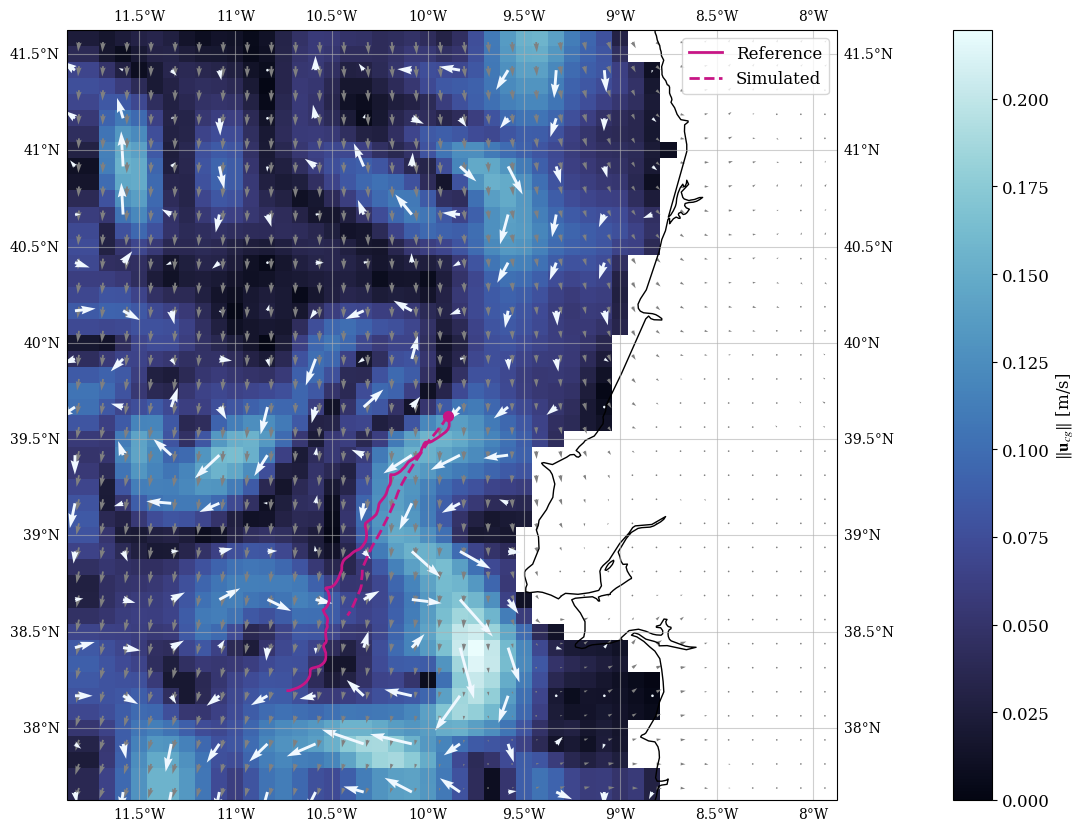

In [106]:
#fig = plt.figure(figsize=(15, 10))

#ax=fig.add_subplot(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
    
#fig, ax = plt.subplots(
#    figsize=(15, 10)
#)

im=ax.pcolormesh(
        vardyn_ds.longitude,
        vardyn_ds.latitude,
        np.sqrt(vardyn_ds.u_cg**2 + vardyn_ds.v_cg**2)[2, ...],
        #vmax=.5,
        vmin=0,
        cmap=cmo.ice,
        shading='nearest'
)

#im = ax.pcolormesh(lon_wind, lat_wind, jnp.sqrt(u_wind[0] ** 2 + v_wind[0] ** 2), vmin=0, cmap=cmo.ice)

quiver = ax.quiver(lon_wind, lat_wind,u_wind[0], v_wind[0], scale=500, color='gray')
num = 3
quiver = ax.quiver(vardyn_ds.longitude[::num], vardyn_ds.latitude[::num],vardyn_ds.u_cg[0][::num, ::num], vardyn_ds.v_cg[0][::num, ::num], scale=3, color='aliceblue')

ax.gridlines(alpha=0.6, draw_labels=True)

ax.plot(melodi_traj.value[:,1], melodi_traj.value[:,0], c='mediumvioletred', label='Reference', linewidth=2)
#ax.plot(traj_mr_tot.value[:,1], traj_mr_tot.value[:,0], '--', c='mediumvioletred',    label='Simulated', linewidth = 3)
ax.plot(traj_mr_tot.value[:-100,1], traj_mr_tot.value[:-100,0], '--', c='mediumvioletred',    label='Simulated', linewidth = 2)
#ax.plot(traj_mr_tot_omb.value[:,1], traj_mr_tot_omb.value[:,0], '--', c='green',    label='Simulated', linewidth = 3)
ax.plot(traj_mr_tot.value[0,1], traj_mr_tot.value[0,0], 'o', c='mediumvioletred')
#ax.plot(traj_mr_tot_leeway.value[:,1], traj_mr_tot_leeway.value[:,0], '--', c='green',    label='Simulated', linewidth = 3)
#ax.scatter(melodi_traj.value[:,1], melodi_traj.value[:,0], c='tab:orange', s=10)
#ax.scatter(traj_mr_tot.value[:,1], traj_mr_tot.value[:,0], c='tab:red', s=10)
#ax.scatter(traj_mr_tot_leeway.value[:,1], traj_mr_tot_leeway.value[:,0], c='red', s=0.1)
#ax.scatter(omb_traj.value[:,1], omb_traj.value[:,0], c='red', s=1)
#ax.set_xlabel('longitude [°]')
#ax.set_ylabel('latitude [°]')
#ax.axis('equal')

ax.legend(loc='upper right')
#ax.set_xlim([0.5,3.5]) 
#ax.set_ylim([69,70])
#ax.set_xlim([-11,-8])
#ax.set_ylim([38,40.5])
fig.colorbar(im, fraction=0.034, pad=0.1, label='$\| \mathbf{u}_{cg} \|$ [m/s]')
#plt.grid()
ax.coastlines()
plt.savefig('/home/samantha/Desktop/MR_Atlantic.png')
#plt.show()